# MachineHack_BuyersTimePrediction

### import the required libraries

In [72]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import VotingRegressor, StackingRegressor

import warnings
warnings.filterwarnings('ignore')

In [73]:
os.chdir('C:\\Users\\animdas\\Documents\\Data Science Projects\\MachineHack_BuyersTimePrediction\\ParticipantData_BTPC')

### Feature Description

1. session_id – Unique identifier for every row
2. session_number – Session type identifier
3. client_agent – Client-side software details
4. device_details – Client-side device details
5. date – Datestamp of the session
6. purchased – Binary value for any purchase done
7. added_in_cart – Binary value for cart activity
8. checked_out – Binary value for checking out successfully
9. time_spent – Total time spent in seconds (Target Column)

### Read the different datasets

In [74]:
train_df = pd.read_csv('train.csv', parse_dates = ['date'])
test_df = pd.read_csv('test.csv', parse_dates = ['date'])

train_df['data'] = 'train'
test_df['data'] = 'test'
df = pd.concat([train_df, test_df])
df.head()

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,data
0,57f879e70d3c5fc2a98102d64c9fd84e,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,236.886,train
1,a5442b0c7c33d0a811e7661e556b2de8,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,1277.455,train
2,305cb1486ed8610c00b37007926cb2c4,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0,21.704,train
3,f2c1ecc9993f0071df91ba178450498c,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,0,1,0,455.201,train
4,e460830ae295e55d2216ebdc761ab9a6,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,0,0,0,1164.877,train


### EDA

In [75]:
def basic_eda(df):
    print('SHAPE')
    print(df.shape)
    print('.' * 100)
    print('\nINFO')
    print(df.info())
    print('.' * 100)
    print('\nMISSING VALUES')
    print('Total Missing:', df.isna().sum().sum())
    print(df.isna().sum())
    print('.' * 100)
    print('\nDUPLICATES')
    print(df.duplicated().sum())
    print('.' * 100)  
    print('\nDESCRIBE')
    print(df.describe())
    

In [76]:
basic_eda(df)

SHAPE
(7756, 10)
....................................................................................................

INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7756 entries, 0 to 2326
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   session_id      7756 non-null   object        
 1   session_number  7756 non-null   int64         
 2   client_agent    7537 non-null   object        
 3   device_details  7756 non-null   object        
 4   date            7756 non-null   datetime64[ns]
 5   purchased       7756 non-null   int64         
 6   added_in_cart   7756 non-null   int64         
 7   checked_out     7756 non-null   int64         
 8   time_spent      5429 non-null   float64       
 9   data            7756 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 666.5+ KB
None
.........................................................

In [77]:
print('Unique values in the dataset:\n')

for i in train_df.columns:
    print('_' * 50)
    print(i + ':', train_df[i].nunique(), train_df[i].dtype)
    print(train_df[i].value_counts())

Unique values in the dataset:

__________________________________________________
session_id: 5429 object
1a807ee6db5aee43fa73f9772f47e468    1
27f2cba72af61db4a55ee9e8a3c3ca21    1
366a3d33bee0503869d4ca2a06695a25    1
be39239df41fe14e0ec1fbe8f6f4e0be    1
d1dbac66ab8e7c316af34b954c02f4ec    1
                                   ..
f5e0a4566025108f2314f97212df9dde    1
04276ad1dbe0059591e1efbedbdcae04    1
b6e0749891b7a405992348bcd6b35ac1    1
7a36447f63c580f293b48a8d837eb9c3    1
14e838e83a0d19f8ae27747fc64a4cd1    1
Name: session_id, Length: 5429, dtype: int64
__________________________________________________
session_number: 610 int64
11      437
22      192
33      132
44      101
55       93
       ... 
3949      1
3696      1
5962      1
7601      1
6083      1
Name: session_number, Length: 610, dtype: int64
__________________________________________________
client_agent: 698 object
Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) M

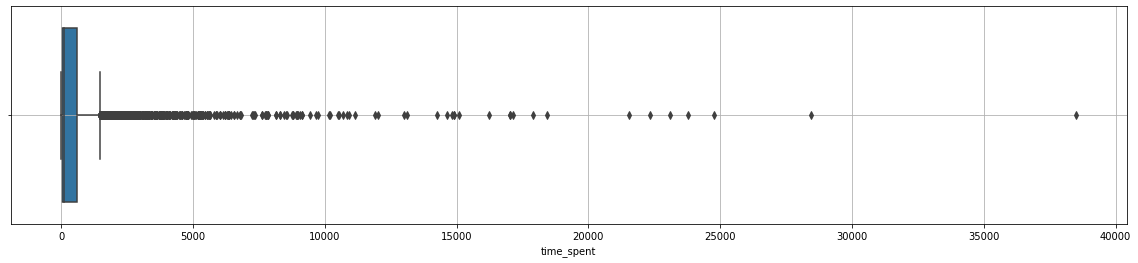

In [78]:
plt.figure(figsize = (20, 4))
sns.boxplot(df['time_spent'])
plt.grid();

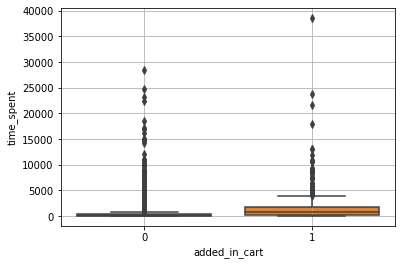

In [79]:
sns.boxplot(x = 'added_in_cart', y = 'time_spent', data = df)
plt.grid();

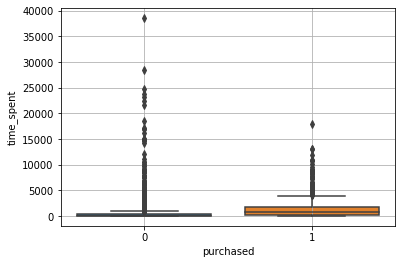

In [80]:
sns.boxplot(x = 'purchased', y = 'time_spent', data = df)
plt.grid();

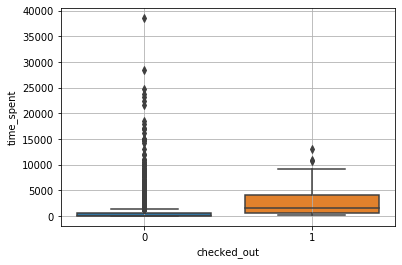

In [81]:
sns.boxplot(x = 'checked_out', y = 'time_spent', data = df)
plt.grid();

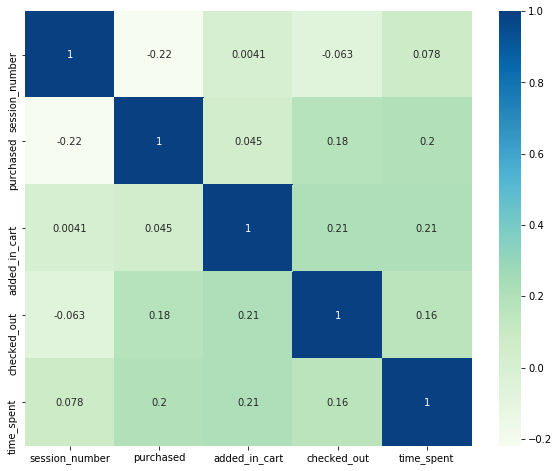

In [82]:
plt.figure(figsize = (10, 8))

sns.heatmap(df.corr(), annot = True, annot_kws = {'size': 10}, cmap = 'GnBu')

### Feature Engineering

In [83]:
df['client_agent'].fillna(df['client_agent'].mode()[0], inplace = True)

In [84]:
df.drop('session_id', axis = 1, inplace = True)

In [85]:
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.weekday

In [86]:
df.skew().sort_values()

month            -0.503060
quarter          -0.468780
day               0.073725
dayofweek         0.094256
year              1.046028
added_in_cart     1.806334
purchased         1.861717
session_number    2.137872
checked_out       7.108323
time_spent        8.037562
dtype: float64

In [87]:
Q1 = df['time_spent'].quantile(0.25)
Q3 = df['time_spent'].quantile(0.75) 
IQR = Q3 - Q1 
lower_range = (Q1 - 1.5 * IQR)
upper_range = (Q3 + 1.5 * IQR)
extreme_lower_range = (Q1 - 3 * IQR)
extreme_upper_range = (Q1 + 3 * IQR)


df['time_spent'] = np.where(df['time_spent'] > upper_range, df['time_spent'].median(), df['time_spent'])

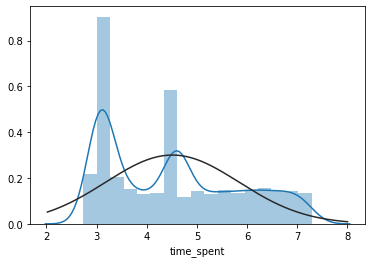

In [88]:
df['time_spent'] = np.log1p(df['time_spent'])

sns.distplot(df['time_spent'], fit = norm)

In [89]:
df['combination'] = df['added_in_cart'].astype('str') + df['purchased'].astype('str') + df['checked_out'].astype('str')

df['combination'].replace(['000', '001', '010', '011', '100', '101', '110', '111'],
                                [int(0), int(1), int(2), int(3), int(4), int(5), int(6), int(7)], inplace = True)

In [90]:
sesh_count = pd.DataFrame(df.session_number.value_counts()[df['session_number']])
sesh_count.reset_index(drop=True, inplace=True)
df['sesh_count'] = sesh_count

In [91]:
train_df = df[df['data'] == 'train']
test_df = df[df['data'] == 'test']

train_df.drop('data', axis = 1, inplace = True)
test_df.drop('data', axis = 1, inplace = True)

In [92]:
tfvect = TfidfVectorizer(min_df = 0.1)
trans = tfvect.fit_transform(train_df['client_agent'])
agent_details = pd.DataFrame(trans.toarray(), columns = tfvect.get_feature_names())
train_df = pd.concat([train_df, agent_details], axis = 1)

trans = tfvect.fit_transform(test_df['client_agent'])
agent_details = pd.DataFrame(trans.toarray(), columns = tfvect.get_feature_names())
test_df = pd.concat([test_df, agent_details], axis = 1)

In [93]:
abs(train_df.corr()['time_spent']).sort_values(ascending = False)

time_spent        1.000000
combination       0.421256
added_in_cart     0.327476
purchased         0.310597
cpu               0.272724
os                0.229897
like              0.173138
mac               0.160204
51                0.160105
nt                0.140598
windows           0.140598
applewebkit       0.132750
khtml             0.132750
rv                0.131992
wow64             0.128855
iphone            0.128013
session_number    0.118890
600               0.104753
macintosh         0.102955
intel             0.102955
36                0.095159
mobile            0.093372
checked_out       0.092448
safari            0.092229
chrome            0.092063
year              0.083669
month             0.082327
quarter           0.077361
product           0.032887
537               0.031320
version           0.024981
dayofweek         0.016845
day               0.011876
sesh_count        0.011425
gecko             0.006158
mozilla           0.000233
Name: time_spent, dtype: flo

### Cross Validation

In [95]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 1).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring = 'neg_mean_squared_error', cv = kf))
    return(rmse)

### Modeling

In [96]:
X = train_df.drop(['time_spent', 'client_agent', 'device_details', 'date'], axis = 1)
y = train_df['time_spent']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 1)

test = test_df.drop(['time_spent', 'client_agent', 'device_details', 'date'], axis = 1)

In [98]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((4886, 35), (4886,), (543, 35), (543,))

In [99]:
cat = CatBoostRegressor(iterations = 200, max_depth = 7, l2_leaf_reg = 0.2, random_strength = 0.2, 
                        verbose = False, random_state = 1) #265, 8, .85, .2 --- 1.1022651545641025


score = rmsle_cv(cat)
print('CatBoost CV Score','\nMean:', score.mean(), 
      '\nSD:', score.std())

CatBoost CV Score 
Mean: 1.1104057860767824 
SD: 0.027706302188422814


In [100]:
xgb = XGBRegressor(n_estimators = 65, max_depth = 2, colsample_bytree = .8, colsample_bylevel = 0.4, 
                   reg_lambda = .65, booster = 'gbtree', random_state = 11, n_jobs = -1) 
                                                                #55, 2, .9, .1, .2, 11 --- 1.1087055455183155

score = rmsle_cv(xgb)
print('XGBoost CV Score','\nMean:', score.mean(), 
      '\nSD:', score.std())

XGBoost CV Score 
Mean: 1.1195610440549433 
SD: 0.029220408966636916


In [101]:
gb = GradientBoostingRegressor(n_estimators = 70, max_depth = 4, loss = 'ls', 
                               min_samples_split = 60, min_samples_leaf = 30, max_features = .45,
                               random_state = 1) #120, 4, 60, 30, .7  --- 1.1041681874624607

score = rmsle_cv(gb)
print('Gradient Boost CV Score','\nMean:', score.mean(), 
      '\nSD:', score.std())

Gradient Boost CV Score 
Mean: 1.1156703562101185 
SD: 0.02721501423071271


In [102]:
lgbm = LGBMRegressor(num_leaves = 60, boosting_type = 'gbdt',   
                              max_depth = 5, reg_lambda = .4, learning_rate = 0.1, 
                              n_estimators = 55, #subsample = 0.2, subsample_freq = 6, 
                              colsample_bytree = .7, n_jobs = -1) #60, 5, .7, 275, .3 --- 1.1053483252809346

score = rmsle_cv(lgbm)
print('LGBM CV Score','\nMean:', score.mean(), 
      '\nSD:', score.std())

LGBM CV Score 
Mean: 1.1144180266627026 
SD: 0.023496240345378235


In [103]:
krr = KernelRidge(alpha = 1, kernel = 'polynomial', degree = 2, coef0 = 2.5)

score = rmsle_cv(krr)
print('KRR CV Score','\nMean:', score.mean(), 
      '\nSD:', score.std())

KRR CV Score 
Mean: 1.1331168411132646 
SD: 0.029886685500515563


In [104]:
estimators = [('gb', gb), ('cat', cat), ('xgb', xgb), ('lgbm', lgbm)]
stack = StackingRegressor(estimators = estimators, 
                        final_estimator = KernelRidge(alpha = 2, kernel = 'polynomial', degree = 2, coef0 = 2.5), 
                        n_jobs = -1)

stack.fit(X, y)
stack_pred = stack.predict(test)

score = rmsle_cv(stack)
print('Stacking Model CV Score','\nMean:', score.mean(), 
      '\nSD:', score.std())

Stacking Model CV Score 
Mean: 1.111070584136193 
SD: 0.026844856097106642


In [105]:
#Final Model

wt_avg_model = VotingRegressor(estimators = [('gb', gb), ('cat', cat), ('xgb', xgb), ('lgbm', lgbm)],
                               weights = [0.1, 0.6, 0.1, 0.2], n_jobs = -1)
score = rmsle_cv(wt_avg_model)
print('Weighted Avg Model CV Score','\nMean:', score.mean(), 
      '\nSD:', score.std())

wt_avg_model.fit(X, y)
wt_avg_pred = wt_avg_model.predict(test)

Weighted Avg Model CV Score 
Mean: 1.1098893765190703 
SD: 0.02694674011107593


In [106]:
submission = pd.DataFrame(abs(np.expm1(wt_avg_pred)), columns = ['time_spent'])
submission.to_csv('submission.csv', index = False)
sub = pd.read_csv('submission.csv')
sub

,time_spent
0,314.806109
1,73.600521
2,206.615581
3,53.904036
4,75.802321
...,...
2322,32.057067
2323,315.141026
2324,80.021022
2325,199.321231


## ========== END ==========